In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
from IPython.display import display
import seaborn as sns
from tqdm import tqdm, trange
from scipy import stats
import datetime
import shutil 
import os
import multiprocessing

from sklearn.externals.joblib import Parallel, delayed

start_codon = 'ATG'

lowercase_synonymous_list = ['ctT', 'ctC', 'ctA', 'ctG', 
                             'gtT', 'gtC', 'gtA', 'gtG', 
                             'gcT', 'gcC', 'gcA', 'gcG', 
                             'ggT', 'ggC', 'ggA', 'ggG', 
                             'ccT', 'ccC', 'ccA', 'ccG', 
                             'acT', 'acC', 'acA', 'acG', 
                             'tcT', 'tcC', 'tcA', 'tcG', 
                             'cgT', 'cgC', 'cgA', 'cgG']

genome_file = '/data3/species-caste-vcfs/DFE-bootstraps-input/polistes-afs-simple.table'
genome_syn_file = '/data3/species-caste-vcfs/DFE-bootstraps-input/polistes-synonymous-afs-simple.table'

pd.set_option('max_colwidth', 125)

/home/arshad/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/arshad/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# List of queen and worker genes
genes_df = pd.read_csv('/home/arshad/Gene_expression/PolistesExpression.csv')
queen_genes = genes_df[genes_df['expression'] == 'Queen']['gene'].tolist()
worker_genes = genes_df[genes_df['expression'] == 'Worker']['gene'].tolist()
non_deg_genes = genes_df[genes_df['expression'] == 'NONDEG']['gene'].tolist()

print(f'Number of Queen genes = {len(queen_genes)}')
print(f'Number of Worker genes = {len(worker_genes)}')

Number of Queen genes = 140
Number of Worker genes = 333


In [3]:
%%time
variants = pd.read_csv('/data3/Arshad_files/species-caste-vcfs/DFE-bootstraps-input/polistes-afs-bootstrap-input.table')
four_fold = pd.read_csv('/data3/Arshad_files/species-caste-vcfs/DFE-bootstraps-input/polistes-synonymous-afs-bootstrap-input.table')

<string>:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 9s, sys: 9.92 s, total: 1min 19s
Wall time: 1min 55s


In [32]:
variants = pd.read_csv('/data4/Ant_genomes/all_ant_invictus_simple.csv')
four_fold = pd.read_csv('/data4/Ant_genomes/synonymous_ant_invictus_simple.csv')

# four_fold = synonymous[synonymous['OG-codon'].isin(lowercase_synonymous_list)]

/home/arshad/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
display(variants.tail(7))
display(four_fold.tail())

,genes,AN,cal_af,effect,AC,AF
141631251,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631252,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631253,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631254,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631255,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631256,NaN,20.0,0.0,intergenic_region,0.0,0.0
141631257,NaN,20.0,0.0,intergenic_region,0.0,0.0


,genes,AN,cal_af,effect,AC,AF
2016263,PdomGENEr1.2-10076,20,0.0,synonymous_variant,0.0,0.0
2016264,PdomGENEr1.2-10076,20,0.0,synonymous_variant,0.0,0.0
2016265,PdomGENEr1.2-10076,20,0.0,synonymous_variant,0.0,0.0
2016266,PdomGENEr1.2-10076,20,0.0,synonymous_variant,0.0,0.0
2016267,PdomGENEr1.2-10076,20,0.0,synonymous_variant,0.0,0.0


In [5]:
variants['effect'].unique()

array(['intergenic_region', 'initiator_codon_variant', 'start_lost',
       'stop_gained', 'missense_variant', 'synonymous_variant',
       'splice_region_variant+synonymous_variant',
       'missense_variant+splice_region_variant',
       'splice_donor_variant+intron_variant',
       'splice_region_variant+intron_variant', 'intron_variant',
       'splice_acceptor_variant+intron_variant',
       'stop_lost+splice_region_variant',
       'splice_region_variant+stop_retained_variant',
       '3_prime_UTR_variant', 'stop_lost', 'splice_region_variant',
       '5_prime_UTR_variant',
       '5_prime_UTR_premature_start_codon_gain_variant',
       'stop_gained+splice_region_variant',
       'start_lost+splice_region_variant',
       'initiator_codon_variant+splice_region_variant',
       'stop_retained_variant', 'non_coding_transcript_exon_variant',
       'splice_region_variant+non_coding_transcript_exon_variant',
       'splice_donor_variant+splice_region_variant+intron_variant',
       '

In [6]:
variants['cal_af'].unique()

array([ 0.,  9.,  1.,  4.,  3.,  2.,  5.,  7.,  6., 10.,  8.])

In [7]:
four_fold['cal_af'].unique()

array([ 0.,  1.,  2.,  4., 10.,  9.,  6.,  3.,  8.,  5.,  7.])

In [8]:
# Caste dfs

queen_df = variants.loc[variants['genes'].isin(queen_genes)]
worker_df = variants.loc[variants['genes'].isin(worker_genes)]
non_deg_df = variants.loc[variants['genes'].isin(non_deg_genes)]

In [9]:
# Four-fold for queen and worker (and non-deg)

queen_four_fold = four_fold.loc[four_fold['genes'].isin(queen_genes)]
worker_four_fold = four_fold.loc[four_fold['genes'].isin(worker_genes)]
non_deg_four_fold = four_fold.loc[four_fold['genes'].isin(non_deg_genes)]

In [10]:
# All

synonymous = variants[variants['effect'].str.contains('synonymous_variant')]
intron = variants[variants['effect'].str.contains('intron_variant')]
intergenic = variants[variants['effect'] == 'intergenic_region']
intragenic = variants[variants['effect'] == 'intragenic_variant']
missense = variants[variants['effect'].str.contains('missense_variant')]
five_prime_UTR = variants[variants['effect'].str.contains('5_prime_UTR')]

In [11]:
#Queen genes

synonymous_queen = queen_df[queen_df['effect'].str.contains('synonymous_variant')]
intron_queen = queen_df[queen_df['effect'].str.contains('synonymous_variant')]
intergenic_queen = queen_df[queen_df['effect'] == 'intergenic_region']
intragenic_queen = queen_df[queen_df['effect'] == 'intragenic_variant']
missense_queen = queen_df[queen_df['effect'].str.contains('missense_variant')]
five_prime_UTR_queen = queen_df[queen_df['effect'].str.contains('5_prime_UTR')]

In [ ]:
#Worker genes

synonymous_worker = worker_df[worker_df['effect'].str.contains('synonymous_variant')]
intron_worker = worker_df[worker_df['effect'].str.contains('synonymous_variant')]
intergenic_worker = worker_df[worker_df['effect'] == 'intergenic_region']
intragenic_worker = worker_df[worker_df['effect'] == 'intragenic_variant']
missense_worker = worker_df[worker_df['effect'].str.contains('missense_variant')]
five_prime_UTR_worker = worker_df[worker_df['effect'].str.contains('5_prime_UTR')]

In [ ]:
# Value counts and converting to sfs

dataframes = [four_fold, intron, intergenic, intragenic, missense, synonymous, five_prime_UTR, queen_four_fold, 
              intron_queen, intergenic_queen, intragenic_queen, missense_queen, five_prime_UTR_queen, 
              worker_four_fold, intron_worker, intragenic_worker, intergenic_worker, missense_worker, 
              five_prime_UTR_worker]
afs_names = ['afs_4_fold', 'afs_intron', 'afs_intergenic', 'afs_intragenic', 'afs_missense', 'afs_synonymous', 
             'afs_5_UTR', 'afs_queen_4_fold', 'afs_queen_intron', 'afs_queen_intergenic', 'afs_queen_intragenic', 
             'afs_queen_missense', 'afs_queen_5_UTR', 'afs_worker_4_fold', 'afs_worker_intron', 'afs_worker_intragenic', 
             'afs_worker_intergenic', 'afs_worker_missense', 'afs_worker_5_UTR']

afs = []
for data, name in zip(dataframes, afs_names):
    df = pd.DataFrame(data['cal_af'].value_counts().sort_index())
    df.columns = [name]
    afs.append(df)
    
afs = pd.concat(afs, axis='columns')
afs = afs.T.fillna(0)
afs.to_csv('folded-bombus-allele-count-caste.csv')
print("File saved and ready to use!!")

# Bootstrapping

### Parallel

In [ ]:
! rm -r /home/arshad/polistes-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run*
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run*
! rm /home/arshad/dfe-alpha-release-2.16/configs/config*

! mkdir /home/arshad/polistes-queen-gene-afs
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen

def sfs_test(i, gene_list):
    gene_queen = queen_df.loc[queen_df['genes'].isin(gene_list)]

    syn_gene_queen = queen_four_fold.loc[queen_four_fold['genes'].isin(gene_list)]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, gene_queen['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/folded-polistes-queen-run-{i}.csv')
    afs.to_csv(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("20\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#polistes-queen")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}/est_dfe.out -o /home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{i}-estimates.txt

In [ ]:
%%time
Parallel(n_jobs=45)(delayed(sfs_test)(i, np.random.choice(queen_genes, len(queen_genes))) for i in trange(5000))

In [ ]:
negative_selection = [] # Will be at the complete top of the script

path_folder = '/home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
#     print(file)
    df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
    df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
    df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
    
    negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
missense_estimates
missense_estimates.to_csv('/home/arshad/polistes-missense-queen-parallel-proper-5kiterations.csv', index=False)

# Whole genome

## Clean up variants df  and four_fold so they are smaller dataframes now

1. synonymous_queen = queen_df[queen_df['effect'].str.contains('synonymous_variant')]
2. intron_queen = queen_df[queen_df['effect'].str.contains('intron_variant')]
3. intergenic_queen = queen_df[queen_df['effect'] == 'intergenic_region']
4. intragenic_queen = queen_df[queen_df['effect'] == 'intragenic_variant']
5. missense_queen = queen_df[queen_df['effect'].str.contains('missense_variant')]
6. five_prime_UTR_queen = queen_df[queen_df['effect'].str.contains('5_prime_UTR')]
6. three_prime_UTR_queen = queen_df[queen_df['effect'].str.contains('3_prime_UTR')]

In [8]:
variants = variants[['genes', 'AN', 'cal_af', 'effect', 'AC', 'AF']]
four_fold = four_fold[['genes', 'AN', 'cal_af', 'effect', 'AC', 'AF']]

In [9]:
# variants.to_csv('/data3/arshad_PNAS_data/newvcfs/final-tables/polistes-afs-bootstrap-input.table', index=False)
# four_fold.to_csv('/data3/arshad_PNAS_data/newvcfs/final-tables/polistes-synonymous-afs-bootstrap-input.table', index=False)

In [10]:
all_genes = [x for x in variants['genes'].unique() if str(x) != 'nan']

In [11]:
len(all_genes)

11768

In [12]:
variants['cal_af'].unique()

array([ 0.,  9.,  1.,  4.,  3.,  2.,  5.,  7.,  6., 10.,  8.])

In [14]:
! rm -r /home/arshad/polistes-worker-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/polistes
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/polistes
! rm -r /home/arshad/dfe-alpha-release-2.16/configs/polistes

! mkdir /home/arshad/polistes-worker-gene-afs
! mkdir /home/arshad/polistes-worker-gene-afs/bootstrapping
! mkdir /home/arshad/polistes-worker-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/polistes-worker-gene-afs/bootstrapping/dfe-estimates-worker
! mkdir /home/arshad/dfe-alpha-release-2.16/configs/polistes
! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/polistes
! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/polistes 

def sfs_whole(i, gene_list):
#     gene_list = worker_genes.copy()
    
    syn_gene_worker = four_fold.loc[four_fold['genes'].isin(gene_list)]
    gene_intergenic_worker = variants[variants['effect'].str.contains('missense_variant', na=False)]
    
    gene_dataframes = [gene_intergenic_worker, syn_gene_worker]
    gene_afs_names = ['intergenic', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, gene_intergenic_worker['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/polistes-worker-gene-afs/bootstrapping/folded-polistes-worker-run-{i}.csv')
    afs.to_csv(f'/home/arshad/polistes-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/polistes-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("20\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#polistes-All")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/polistes/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/polistes/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/polistes/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/polistes/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/polistes/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-worker-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/polistes/run-{i}/\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/polistes/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/polistes/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/polistes/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/polistes/run-{i}/est_dfe.out -o /home/arshad/polistes-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-{i}-estimates.txt

In [15]:
for i in range(1):
    sfs_whole(i, all_genes)

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
prop_muts_in_s_ranges.c: version 1.02
Output file expected
Opened file /home/arshad/polistes-worker-gene-afs/bootstrapping/dfe-estimates-worker/run-0-estimates.txt for write, overwrite mode.
n2 132.650000
es -7574.044953
beta 0.118800
mean_ns 1004697.063015
lower 0.000000 upper 1.000000 area 0.159242
lower 1.000000 upper 10.000000 area 0.050100
lower 10.000000 upper 100.000000 area 0.065863
lower 100.000000 upper -99.000000 area 0.724795
Total area 1.000000


In [15]:
%%time
Parallel(n_jobs=20)(delayed(sfs_whole)(i, np.random.choice(all_genes, len(all_genes))) for i in trange(5000))

  1%|          | 39/5000 [00:19<1:57:02,  1.42s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'
nohup: ignorin

  1%|          | 40/5000 [01:40<41:38:53, 30.23s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 42/5000 [01:40<29:10:35, 21.19s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 45/5000 [01:40<20:26:18, 14.85s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 46/5000 [01:41<14:22:40, 10.45s/it]

nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 49/5000 [01:41<10:06:46,  7.35s/it]

nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 50/5000 [01:42<7:19:51,  5.33s/it] 

nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 51/5000 [01:42<5:13:23,  3.80s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 52/5000 [01:42<3:49:52,  2.79s/it]

nohup: ignoring input and appending output to 'nohup.out'
nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 53/5000 [01:45<3:52:54,  2.82s/it]

nohup: ignoring input and appending output to 'nohup.out'


  1%|          | 54/5000 [01:46<3:02:45,  2.22s/it]

KeyboardInterrupt: 

In [16]:
negative_selection = [] # Will be at the complete top of the script

path_folder = '/home/arshad/polistes-worker-gene-afs/bootstrapping/dfe-estimates-worker/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    df = pd.read_csv(f'{path_folder}/{file}', sep=' ', header=None)
    df.columns = ['rand1', 'rand2', 'one', 'rand3', 'rand4', 'ten', 'rand5', 'rand6', 'hundred', 'rand7', 
                  'rand8', 'infinity', 'check']
    df.drop(columns =[column for column in df.columns if 'rand' in column], inplace=True)
    
    negative_selection.append(df)

missense_estimates = pd.concat(negative_selection)
missense_estimates
missense_estimates.to_csv('/home/arshad/polistes-intergenic-all-parallel-proper-5kiterations.csv', index=False) #<-----


 77%|███████▋  | 56/73 [00:00<00:01, 13.82it/s]
74it [00:00, 19.03it/s]                        
102it [00:00, 26.41it/s]
130it [00:01, 36.25it/s]
162it [00:01, 49.36it/s]
196it [00:01, 65.96it/s]
227it [00:01, 86.25it/s]
259it [00:01, 110.37it/s]
291it [00:01, 137.34it/s]
321it [00:01, 162.69it/s]
351it [00:01, 187.78it/s]
383it [00:01, 213.98it/s]
418it [00:01, 241.09it/s]
453it [00:02, 265.54it/s]
486it [00:02, 275.45it/s]
521it [00:02, 294.21it/s]
556it [00:02, 308.09it/s]
591it [00:02, 319.11it/s]
626it [00:02, 326.96it/s]
661it [00:02, 333.26it/s]
696it [00:02, 324.33it/s]
731it [00:02, 329.88it/s]
766it [00:02, 333.85it/s]
801it [00:03, 336.55it/s]
836it [00:03, 339.56it/s]
871it [00:03, 340.51it/s]
906it [00:03, 342.63it/s]
941it [00:03, 337.81it/s]
975it [00:03, 335.80it/s]
1010it [00:03, 338.88it/s]
1044it [00:03, 328.63it/s]
1078it [00:03, 331.72it/s]
1112it [00:03, 332.06it/s]
1147it [00:04, 337.09it/s]
1181it [00:04, 269.57it/s]
1211it [00:04, 262.94it/s]
1239it [00:04, 23

# Point estimate

In [ ]:
! rm -r /home/arshad/polistes-queen-gene-afs
! rm -r /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run*
! rm -r /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run*
! rm /home/arshad/dfe-alpha-release-2.16/configs/config*

! mkdir /home/arshad/polistes-queen-gene-afs
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs
! mkdir /home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen

def sfs_test(i, gene_list):
    gene_queen = queen_df.loc[queen_df['genes'].isin(gene_list)]

    syn_gene_queen = queen_four_fold.loc[queen_four_fold['genes'].isin(gene_list)]
    gene_missense_queen = gene_queen[gene_queen['effect'].str.contains('missense_variant')]
    
    gene_dataframes = [gene_missense_queen, syn_gene_queen]
    gene_afs_names = ['missense', 'four_fold']
    
    afs = []
    for data, name in zip(gene_dataframes, gene_afs_names):
        indices = np.arange(0, gene_queen['AN'].max() + 1, 1)
        df = pd.DataFrame(data['cal_af'].value_counts().reindex(index=indices, fill_value='0').sort_index())
        df.columns = [name]
        afs.append(df)
        
    afs = pd.concat(afs, axis='columns')
    afs = afs.T
#     display(afs.head())
    
    afs.to_csv(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/folded-polistes-queen-run-{i}.csv')
    afs.to_csv(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', sep=' ', index=False, header=False)
    
    # Make sfs.txt file for dfe-alpha file
    
    with open(f'/home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt', 'r+') as sfs_file:
        file_data = sfs_file.read()
        sfs_file.seek(0, 0)
        sfs_file.write("1\n".rstrip('\r\n') + '\n')
        sfs_file.write("20\n".rstrip('\r\n') + '\n')
        sfs_file.write(file_data)
        sfs_file.write("#polistes-queen")
        sfs_file.close()
    
#     Config 1 file

    ! mkdir /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}\n") 
        sfs_file.write("site_class 0\n")
        sfs_file.write("fold       1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("search_n2       1\n")
        sfs_file.write("#n2     1000\n")
        sfs_file.write("t2_variable     1\n")
        sfs_file.write("t2              1000\n")
        sfs_file.close()

  # Config 2 file
    ! mkdir /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}

    with open(f'/home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt', 'a') as sfs_file:
        sfs_file.write("data_path_1     /home/arshad/dfe-alpha-release-2.16/data/\n")
        sfs_file.write("data_path_2     /home/arshad/dfe-alpha-release-2.16/data-epoch-3/\n")
        sfs_file.write(f"sfs_input_file  /home/arshad/polistes-queen-gene-afs/bootstrapping/sfs/sfs-run-{i}.txt\n")
        sfs_file.write(f"est_dfe_results_dir    /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}\n") 
        sfs_file.write(f"est_dfe_demography_results_file   /home/arshad/dfe-alpha-release-2.16/site-class-0-output/bootstrap/run-{i}/est_dfe.out\n") 
        sfs_file.write("site_class 1\n")
        sfs_file.write("fold 1\n")
        sfs_file.write("epochs  2\n")
        sfs_file.write("mean_s_variable 1\n")
        sfs_file.write("mean_s -0.001\n")
        sfs_file.write("beta_variable 1\n")
        sfs_file.write("beta 0.005\n")
        sfs_file.close()

    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-1.txt
    ! nohup /home/arshad/dfe-alpha-release-2.16/est_dfe -c /home/arshad/dfe-alpha-release-2.16/configs/config-{i}-2.txt
    ! /home/arshad/dfe-alpha-release-2.16/prop_muts_in_s_ranges -c /home/arshad/dfe-alpha-release-2.16/results_dir_sel/bootstrap/run-{i}/est_dfe.out -o /home/arshad/polistes-queen-gene-afs/bootstrapping/dfe-estimates-queen/run-{i}-estimates.txt

In [ ]:
%%time
Parallel(n_jobs=45)(delayed(sfs_test)(i, np.random.choice(queen_genes, len(queen_genes))) for i in trange(5000))

In [ ]:
for i in trange(1):
    sfs_test(i, queen_genes)

In [31]:
check_length = pd.read_csv('/home/arshad/polistes-intron-all-parallel-proper-5kiterations.csv')
check_length.head()

,one,ten,hundred,infinity,check
0,1.0,0.0,0.0,0.0,NaN
1,1.0,0.0,0.0,0.0,NaN
2,1.0,0.0,0.0,0.0,NaN
3,1.0,0.0,0.0,0.0,NaN
4,1.0,0.0,0.0,0.0,NaN


In [32]:
len(check_length)

5000

In [33]:
np.unique(check_length['one'])

array([1.])

In [15]:
missense = variants[variants['effect'].str.contains('missense_variant', na=False)]
print(len(missense))
display(missense.head())

11515430


,genes,AN,cal_af,effect,AC,AF
8537,PdomGENEr1.2-01131,20.0,0.0,missense_variant,0.0,0.0
8538,PdomGENEr1.2-01131,20.0,0.0,missense_variant,0.0,0.0
8539,PdomGENEr1.2-01131,20.0,0.0,missense_variant,0.0,0.0
8542,PdomGENEr1.2-01131,20.0,0.0,missense_variant,0.0,0.0
8544,PdomGENEr1.2-01131,20.0,0.0,missense_variant,0.0,0.0


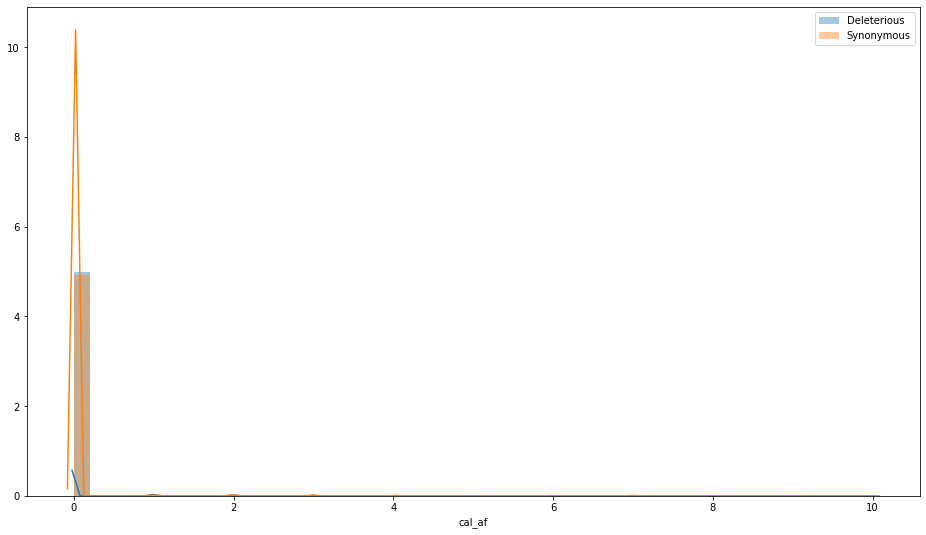

In [16]:
graph.figure(figsize=(16,9))
sns.distplot(missense['cal_af'], label='Deleterious')
sns.distplot(four_fold['cal_af'], label='Synonymous')
graph.legend()
graph.show()